In [1]:
# TODO:
# DONE - load 3 documents: animal farm, jdugement1, judgement2
# DONE - extract text from those documents - split by pages
# DONE - convert pages to embeddings

# DONE - visualise tSNE 2D spacing of embedings for each document individually - Do you see clusters within document?
### DONE - anotate points on the plot with page numbers - do adjacent pages lie close ot each other?
### DONE - This may be not necesarily true because page 1 (introduction) may be unrelated to page 2 (begining of a story)
# DONE - visualise tSNE 2D spacing of all documents together. - does Novel lie further away from Judgements, then judgements from each other?
### DONE - is there much overlap between emebdings of pages of the 2 judgements? -> No!

# DONE - create some question with some sufficient context - produce embedding
# DONE - compute embedding between that question and embedings of all pages of your 3 documents
# DONE - plot distribution of distances for these documents - overlay on top of each other - do you see what you expected?
# DONE - lot timeseries
# DONE - what distance metric is best? - mean of top5 similar pages, mean of top10 similar pages, mean of all pages? 
### DONE - you should get a feel from the distribution.

In [57]:
import sys, os
import numpy as np
from sklearn.manifold import TSNE
from tqdm import tqdm
from langchain.embeddings import HuggingFaceEmbeddings
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

sys.path.append('/Users/janek/Coding/PersonalProjects/playground/pdfGPT/server_aws/src/app/')
import parse_pdf as parser
import utils
embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2")

### get documents

In [3]:
documents = {
    'animal_farm': {'path': '/Users/janek/Coding/PersonalProjects/playground/pdfGPT/assets/orwellanimalfarm.pdf'},
    'dobbs_v_jackson': {'path': '/Users/janek/Coding/PersonalProjects/playground/pdfGPT/assets/dobbs_v_jackson.pdf'},
    'phillip_v_barclays': {'path': '/Users/janek/Coding/PersonalProjects/playground/pdfGPT/assets/phillip_vs_barclays.pdf'}
}

In [4]:
# get texts
for pdf_name in documents:
    pdf_file = documents[pdf_name]['path']
    documents[pdf_name]['pages'] = parser.get_pages(pdf_file, pdf_name)
    
# get embeddings
for pdf_name in tqdm(documents):
    texts = list(documents[pdf_name]['pages'].values())
    embeddings = embedding_model.embed_documents(texts)
    embeddings = {i: embd for i, embd in enumerate(embeddings)}
    documents[pdf_name]['embeddings'] = embeddings

### tSNE visualisation - individually

In [30]:
for pdf_name in tqdm(documents):
    embeddings = np.array(list(documents[pdf_name]['embeddings'].values()))
    embed_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(embeddings)
    documents[pdf_name]['embed_tsne'] = embed_tsne

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.41s/it]


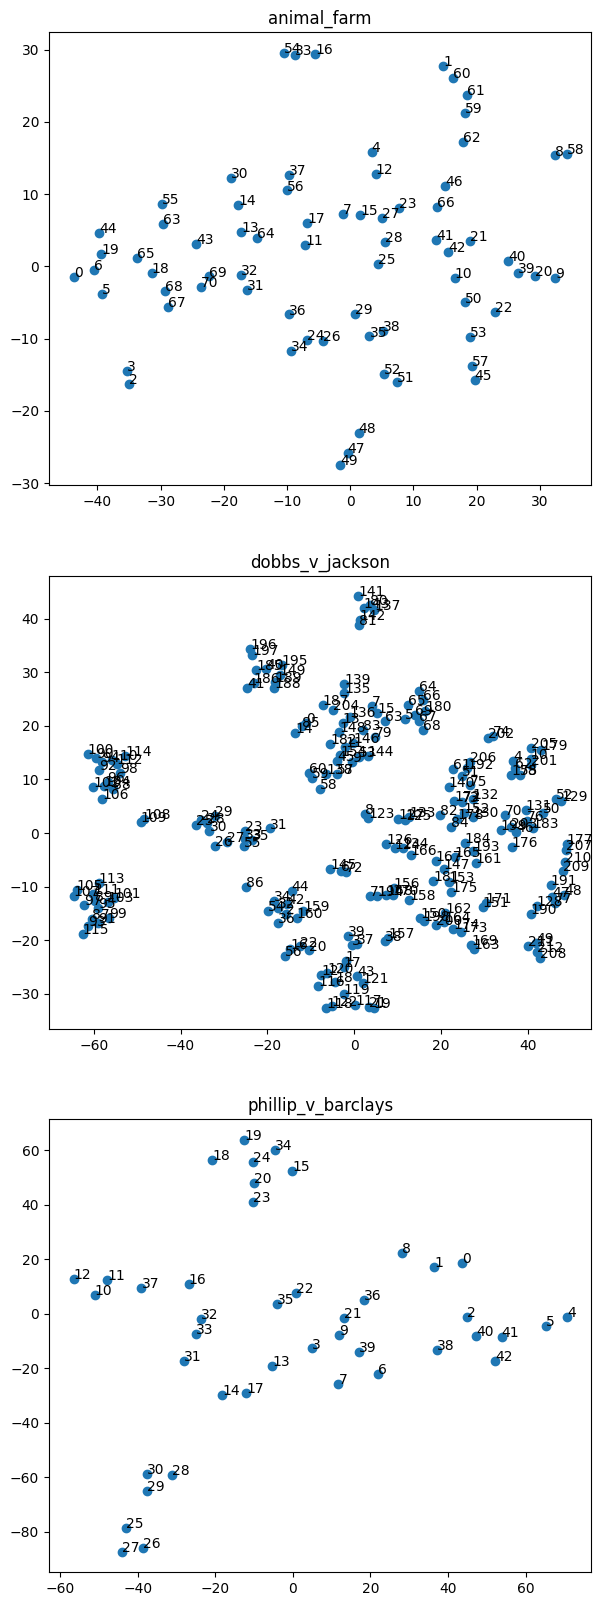

In [36]:
fig, ax = plt.subplots(3,1,figsize=(7,20))
for i, pdf_name in enumerate(documents):
    embed_tsne = documents[pdf_name]['embed_tsne']
    ax[i].set_title(pdf_name)
    ax[i].scatter(embed_tsne[:,0], embed_tsne[:,1])
    for j in np.arange(len(embed_tsne)):
        ax[i].annotate(j, embed_tsne[j])
plt.show()

In [ ]:
# Notes about phillip_v_barclays
### pages 25-30 are all close to each other - they all include examples of other cases
### pages 2 (intro) and pages 40,41,42 (conclusion) are also close to each other

# Notes on dobbs_v_jackson
### we also see some definite clusters

### tSNE visualisation - together

In [38]:
embeddings_combined = []
embeddings_annotations = []
for pdf_name, annotation in zip(documents, ['AF', 'DJ', 'PB']):
    embeddings = list(documents[pdf_name]['embeddings'].values())
    embeddings_annotations += [annotation]*len(embeddings)
    embeddings_combined += embeddings
embeddings_combined = np.array(embeddings_combined)

In [ ]:
embed_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(embeddings_combined)

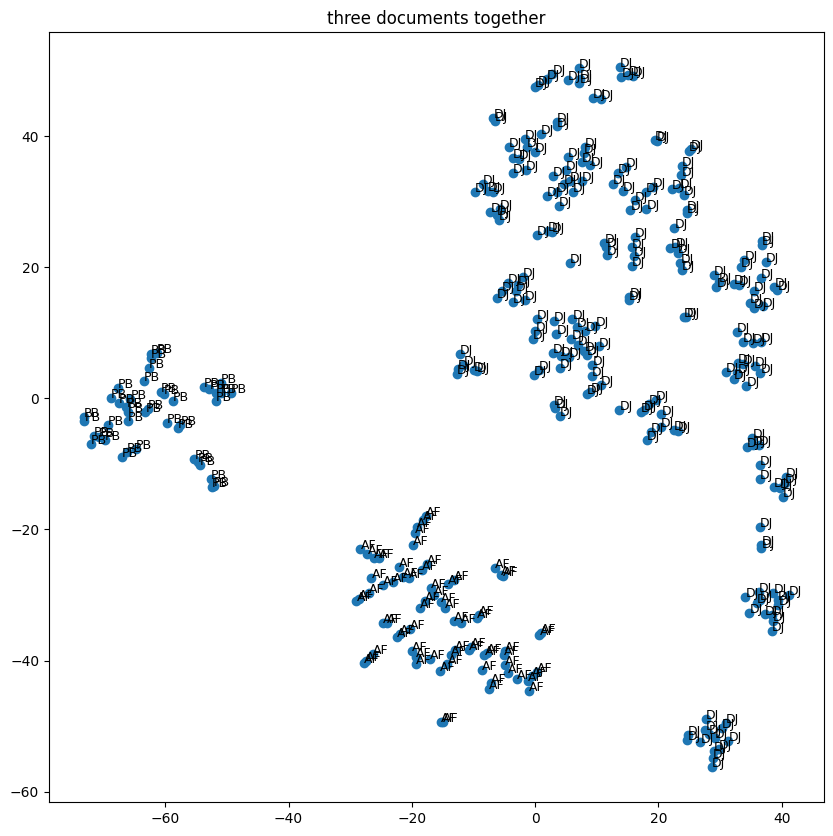

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('three documents together')
ax.scatter(embed_tsne[:,0], embed_tsne[:,1])
for j in np.arange(len(embeddings_annotations)):
    ax.annotate(embeddings_annotations[j], embed_tsne[j], fontsize=9)
plt.show()

### <font color='red'>Observation:</font>
<font color='red'>As desired all documents are quite separated from each other. One may wonder if this is because their differences or perhaps because of soem artefacts in the text.</font>


### Pull out random texts and see if they have some artefacts that could make the source distinguishable

In [50]:
ids = [4,15,33]
for pdf_name, i in zip(documents, ids):
    print(pdf_name)
    print(documents[pdf_name]['pages'][i], '\n')

animal_farm
speaking four large rats had crept out of their holes and were sitting on their hindquarters, listening to him. The dogs had suddenly caught sight of them, and it was only by a swift dash for their holes that the rats saved their lives. Major raised his trotter for silence. "Comrades," he said, "here is a point that must be settled. The wild creatures, such as rats and rabbits-are they our friends or our enemies? Let us put it to the vote. I propose this question to the meeting: Are rats comrades?" The vote was taken at once, and it was agreed by an overwhelming majority that rats were comrades. There were only four dissentients, the three dogs and the cat, who was afterwards discovered to have voted on both sides. Major continued: "I have little more to say. I merely repeat, remember always your duty of enmity towards Man and all his ways. Whatever goes upon two legs is an enemy. Whatever goes upon four legs, or has wings, is a friend. And remember also that in fighting ag

### Compare embeddings to some search context about documents

In [77]:
documents['animal_farm']['search_context'] = ["I am looking for documents related to George Orwell's book Animal Farm. In this book animals are main characters and they rebel agianst humans. They all live on a farm and impersonate human characteristics."]
documents['dobbs_v_jackson']['search_context'] = ["I need to evaluate impact of a court judegement whos rulling is related to healthcare system. My case is related to pregnancy and endegering women life, if passed."]
documents['phillip_v_barclays']['search_context'] = ["I have a case where a client introduced charges against their bank, accusing them of handlign a payment while being aware of the client being defrauded."]

for pdf_name in documents:
    search_context = documents[pdf_name]['search_context']
    search_context_embed = embedding_model.embed_documents(search_context)
    documents[pdf_name]['search_context_embed'] = search_context_embed

for context_name in documents:
    context_embed = documents[context_name]['search_context_embed']
    documents[context_name]['similarity_to_search_context'] = {}
    for pdf_name in documents:
        text_embeds = np.array(list(documents[pdf_name]['embeddings'].values()))
        similarity = cosine_similarity(context_embed, text_embeds)
        documents[context_name]['similarity_to_search_context'][pdf_name] = similarity

In [98]:
def plot_context_to_page_similarity_distribution(similarity, context_name):
    fig, ax = plt.subplots(figsize=(12,4))
    ax.set_title(f'Context search for: {context_name}')
    for pdf_name in similarity:
        scores = similarity[pdf_name][0]
        ax.hist(scores, bins=80, range=(-1,1), alpha=0.5, label=pdf_name)
    ax.legend()
    ax.set_xlabel('similarity [the greater the more relevant]')
    plt.show()

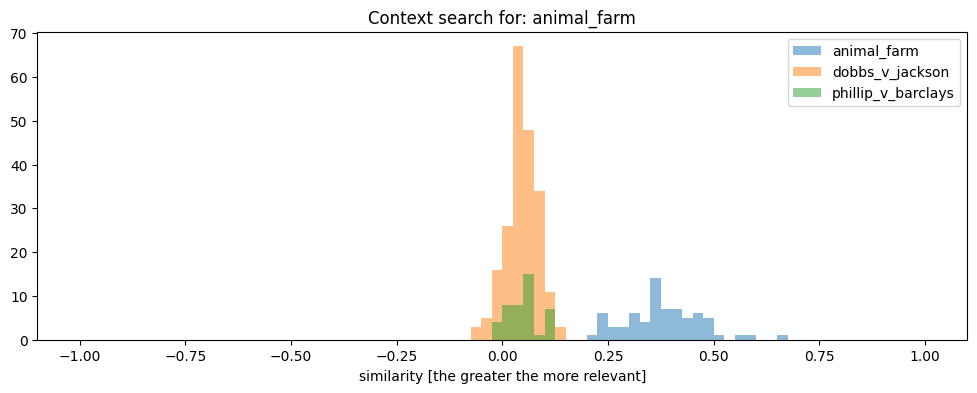

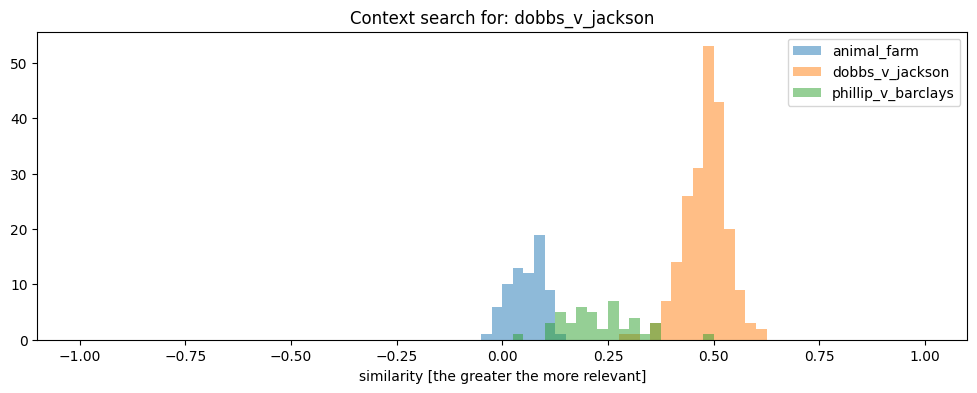

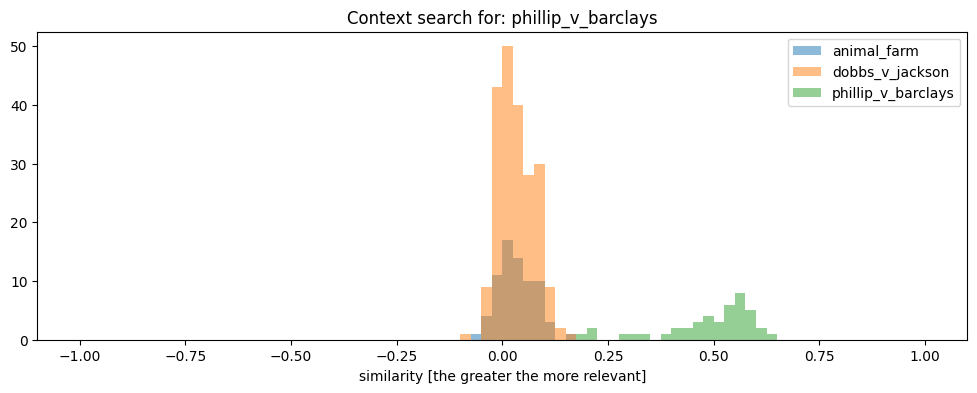

In [99]:
for context_name in documents:
    plot_context_to_page_similarity_distribution(documents[context_name]['similarity_to_search_context'], context_name)

### Compare distance to search context across the document as a timeseries

In [100]:
def plot_context_to_page_similarity_timeseries(similarity, context_name):
    fig, ax = plt.subplots(figsize=(12,4))
    ax.set_title(f'Context search for: {context_name}')
    for pdf_name in similarity:
        scores = similarity[pdf_name][0]
        x = np.arange(len(scores))
        ax.plot(x, scores, linewidth=2, alpha=0.5, label=pdf_name)
    ax.legend()
    ax.set_xlabel('similarity [the greater the more relevant]')
    plt.show()

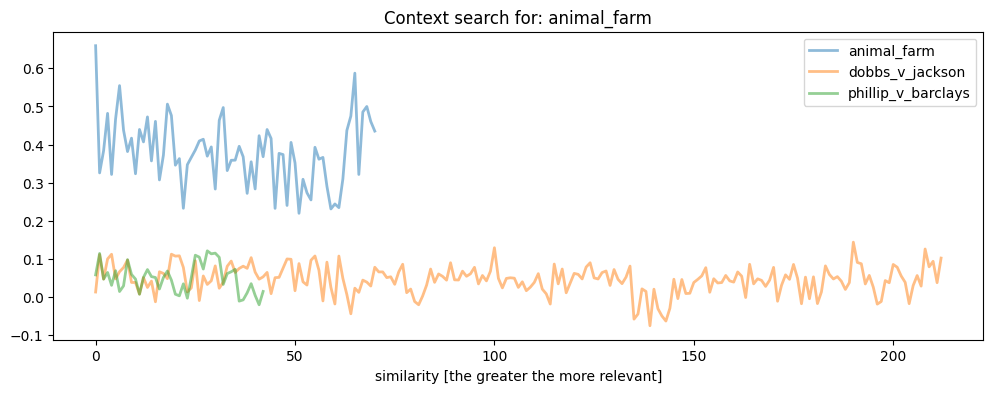

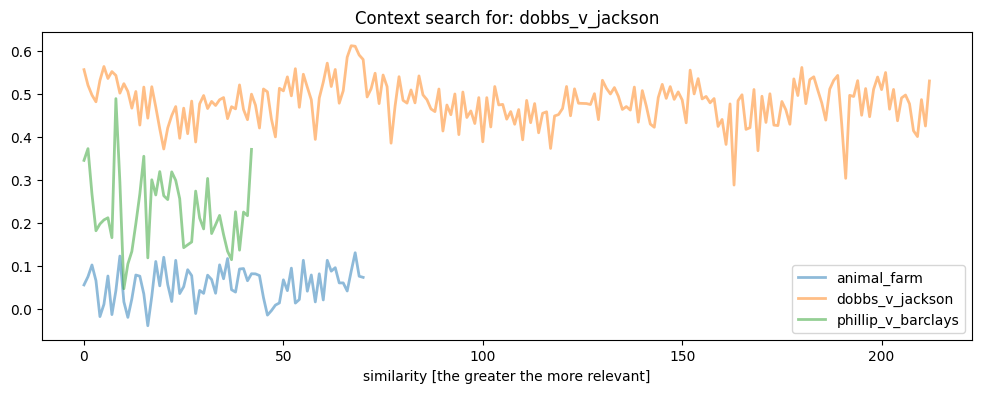

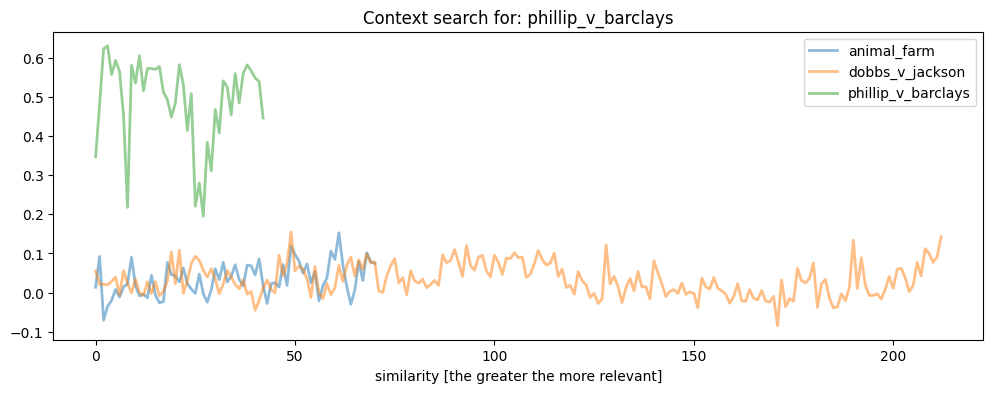

In [101]:
for context_name in documents:
    plot_context_to_page_similarity_timeseries(documents[context_name]['similarity_to_search_context'], context_name)

### <font color='red'>Observation:</font>
<font color='red'>timeseries seems quite eratic from apage to page, actually all pages have somewhat similar distance to the question - perhaps due to language that is being used.</font>

<font color='red'>One positive effect this has for us:</font>
* <font color='red'>that choice of aggregation method might be not critical to start with. perhaps later when we start relying on finer differences maybe. But based of those 3 documents. if it's: mean, median, mean of top10 - it doesn't matter. </font>


### compute distance from context search to documents

In [147]:
def median_aggregation(context_embed, text_embeds):
    doc_embed = np.median(text_embeds, axis=0, keepdims=True)
    similarity = cosine_similarity(context_embed, doc_embed)
    return similarity[0][0]

def mean_aggregation(context_embed, text_embeds):
    doc_embed = np.mean(text_embeds, axis=0, keepdims=True)
    similarity = cosine_similarity(context_embed, doc_embed)
    return similarity[0][0]

def mean_top10_pages_aggregation(context_embed, text_embeds):
    topN = 10
    similiarities = cosine_similarity(context_embed, text_embeds)[0]
    topN_indexes = np.argsort(similiarities)[::-1][:topN]
    relevant_embeds = text_embeds[topN_indexes]
    doc_embed = np.mean(relevant_embeds, axis=0, keepdims=True)
    similarity = cosine_similarity(context_embed, doc_embed)
    return similarity[0][0]

In [148]:
median_similarity = {}
mean_similarity = {}
mean_top10_similarity = {}

for context_name in documents:
    context_embed = documents[context_name]['search_context_embed']
    context_embed = np.array(context_embed)
    
    median_similarity[context_name] = {}
    mean_similarity[context_name] = {}
    mean_top10_similarity[context_name] = {}
    
    for pdf_name in documents:
        text_embeds = np.array(list(documents[pdf_name]['embeddings'].values()))
        median_similarity[context_name][pdf_name] = median_aggregation(context_embed, text_embeds)
        mean_similarity[context_name][pdf_name] = mean_aggregation(context_embed, text_embeds)
        mean_top10_similarity[context_name][pdf_name] = mean_top10_pages_aggregation(context_embed, text_embeds)

In [149]:
median_similarity

{'animal_farm': {'animal_farm': 0.4863336346318372,
  'dobbs_v_jackson': 0.054688898454298904,
  'phillip_v_barclays': 0.05544733760895751},
 'dobbs_v_jackson': {'animal_farm': 0.07169791228855535,
  'dobbs_v_jackson': 0.5755887881728141,
  'phillip_v_barclays': 0.28632056734032235},
 'phillip_v_barclays': {'animal_farm': 0.042320455691370204,
  'dobbs_v_jackson': 0.031750209892352235,
  'phillip_v_barclays': 0.6251225538743044}}

In [150]:
mean_similarity

{'animal_farm': {'animal_farm': 0.48623433329048166,
  'dobbs_v_jackson': 0.05547777965464302,
  'phillip_v_barclays': 0.06384867091855675},
 'dobbs_v_jackson': {'animal_farm': 0.07306567239727556,
  'dobbs_v_jackson': 0.5813521451218029,
  'phillip_v_barclays': 0.2918082164949993},
 'phillip_v_barclays': {'animal_farm': 0.04462986766417373,
  'dobbs_v_jackson': 0.04007050152781781,
  'phillip_v_barclays': 0.622528052229823}}

In [151]:
mean_top10_similarity

{'animal_farm': {'animal_farm': 0.6026617793191198,
  'dobbs_v_jackson': 0.13949986867196673,
  'phillip_v_barclays': 0.13164533789148553},
 'dobbs_v_jackson': {'animal_farm': 0.1422317620263598,
  'dobbs_v_jackson': 0.6245911095421282,
  'phillip_v_barclays': 0.42977635887692595},
 'phillip_v_barclays': {'animal_farm': 0.12421509337122641,
  'dobbs_v_jackson': 0.14681095026090574,
  'phillip_v_barclays': 0.684783720491819}}